# Question Answering Model

### 1. Reading datasets

### 1.1. Import libraries

In [1]:
import pandas as pd
import re
import string
import spacy
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

random_state_val = 0

In [2]:
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from transformers import TrainingArguments
from transformers import DefaultDataCollator
from transformers import Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split



tokenizer_ori = BertTokenizer.from_pretrained('bert-large-cased-whole-word-masking-finetuned-squad')
model_ori = BertForQuestionAnswering.from_pretrained('bert-large-cased-whole-word-masking-finetuned-squad')

### 1.2. Read news_dataset

In [ ]:
df_news_dataset = pd.read_csv("news_dataset.csv", encoding = "ISO-8859-1")
df_news_dataset.rename(columns={"article":"context"},inplace=True)

In [ ]:
df_news_sample = df_news_dataset.sample(n=30,random_state = random_state_val)

In [ ]:
df_qa = pd.read_csv("qa_article.tsv",sep="\t")


In [8]:
df_news_qa = pd.merge(df_news_sample,df_qa,how="inner",on="id")
df_news_qa.head()


,id,author,date,year,month,topic,context,question,answer_text
0,18456,Victor Mather,13/02/2017,2017,2,politics,At least six members of the Super New Englan...,Where did Blount reveal his decision?,on Fox Sports in a radio interview on The Rich...
1,18308,Ken Belson,8/02/2017,2017,2,sports,"HOUSTON ? There was the game on the field, ...",What did Mr. Bush do from a wheelchair on the ...,Mr. Bush did the opening coin toss
2,17636,Ron Lieber,14/01/2017,2017,1,business,When Wells Fargo announced its quarterly earni...,Why were not many customers exactly pleased,the number of new consumer checking accounts h...
3,17938,Dale Russakoff,29/01/2017,2017,1,politics,When Indira Islas was in third grade at Centen...,How many hours did Indira work as a volunteer?,"over 1, 000 hours a year"
4,18070,Laurie Goodstein,30/01/2017,2017,1,crime,"Over the past decade, Christians in the United...",When the United States admitted almost as many...,In 2016


Pronouns in the answer should be avoided as much as possible because they may be subject to changes through coreference resolution. Threfore check ronouns in the answer

In [9]:
nlp = spacy.load("en_core_web_sm")
cnt_pron_checker=0
def pron_checker(text):
    global cnt_pron_checker
    if cnt_pron_checker % 10000 == 0:
        print("count",cnt_pron_checker)
    cnt_pron_checker+=1

    doc = nlp(text)

    pron_num = len([1 for token in doc if token.pos_ == "PRON"])
    return pron_num


In [10]:
df_news_qa["cnt_pron_answer"] = df_news_qa["answer_text"].apply(lambda x:pron_checker(x))
display(df_news_qa[df_news_qa["cnt_pron_answer"]>0])
print(df_news_qa[df_news_qa["cnt_pron_answer"]>0]["answer_text"].values[0])

count 0


,id,author,date,year,month,topic,context,question,answer_text,cnt_pron_answer
23,17653,Anahad O?Connor,18/01/2017,2017,1,lifestyle,What do households on food stamps buy at the g...,What did the United States Department of Agric...,a detailed report that provides a glimpse into...,2


a detailed report that provides a glimpse into the shopping cart of the typical household that receives food stamps


Coreference resolution is not affected because only relative pronouns are caught as pronouns.

### 1.3. Read SQuAD dataset

In [12]:
from datasets import load_dataset

dic_squad = load_dataset("squad")
dic_squad = {split: dset.to_pandas() for split, dset in dic_squad.flatten().items()}

squad_cols = ["id","title", "question", "answers.text", "answers.answer_start", "context"]
df_squad = dic_squad["train"][squad_cols] # "valid" is not used since the number of answer is different.

df_squad["answers.text"] = df_squad["answers.text"].apply(lambda x:x[0])
df_squad["answers.answer_start"] = df_squad["answers.answer_start"].apply(lambda x:x[0])

df_squad.columns = ["id","title","question","answer_text","answer_start_position","context"]
df_squad.head()


Found cached dataset parquet (C:/Users/sacas/.cache/huggingface/datasets/parquet/plain_text-57edf78d6033ac9a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

,id,title,question,answer_text,answer_start_position,context
0,5733be284776f41900661182,University_of_Notre_Dame,To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,"Architecturally, the school has a Catholic cha..."
1,5733be284776f4190066117f,University_of_Notre_Dame,What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,"Architecturally, the school has a Catholic cha..."
2,5733be284776f41900661180,University_of_Notre_Dame,The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,"Architecturally, the school has a Catholic cha..."
3,5733be284776f41900661181,University_of_Notre_Dame,What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,"Architecturally, the school has a Catholic cha..."
4,5733be284776f4190066117e,University_of_Notre_Dame,What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,"Architecturally, the school has a Catholic cha..."


In [13]:
df_squad["cnt_pron_answer"] = df_squad["answer_text"].apply(lambda x:pron_checker(x))

count 10000
count 20000
count 30000
count 40000
count 50000
count 60000
count 70000
count 80000


In [14]:
df_squad["cnt_pron_answer"].value_counts()

cnt_pron_answer
0    84128
1     2890
2      445
3      102
4       22
5        9
6        3
Name: count, dtype: int64

If pronouns exist within the answer, it is anticipated that Coreference Resolution may alter the answer's pronouns. Therefore, they are removed.

In [15]:
df_squad_select = df_squad.copy()[df_squad["cnt_pron_answer"]==0]
df_squad_select.reset_index(drop=True, inplace=True)

### 2. Exploratory Data Analysis (EDA)

### 2.1. Confirm missing values and types

In [17]:
df_news_qa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               30 non-null     int64 
 1   author           30 non-null     object
 2   date             30 non-null     object
 3   year             30 non-null     object
 4   month            30 non-null     object
 5   topic            30 non-null     object
 6   context          30 non-null     object
 7   question         30 non-null     object
 8   answer_text      30 non-null     object
 9   cnt_pron_answer  30 non-null     int64 
dtypes: int64(2), object(8)
memory usage: 2.5+ KB


In [18]:
df_squad_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84128 entries, 0 to 84127
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     84128 non-null  object
 1   title                  84128 non-null  object
 2   question               84128 non-null  object
 3   answer_text            84128 non-null  object
 4   answer_start_position  84128 non-null  int32 
 5   context                84128 non-null  object
 6   cnt_pron_answer        84128 non-null  int64 
dtypes: int32(1), int64(1), object(5)
memory usage: 4.2+ MB


There are no missing values in both the news dataset and the SQuAD dataset. There are no particular issues with the data types too.

### 2.2. Check the length of context, question and answer

mean context length 1158.9333333333334
meadian context length 1042.5


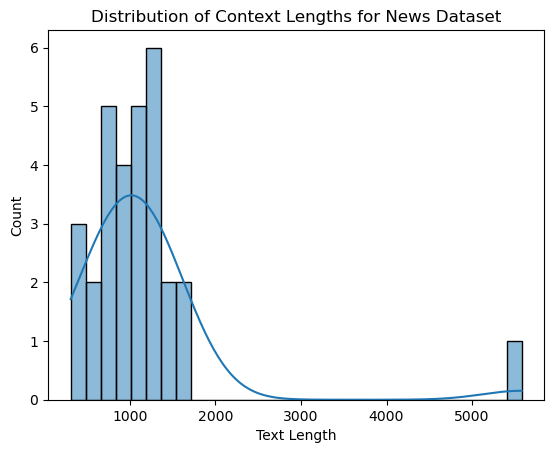

mean context length 119.49197651198175
meadian context length 110.0


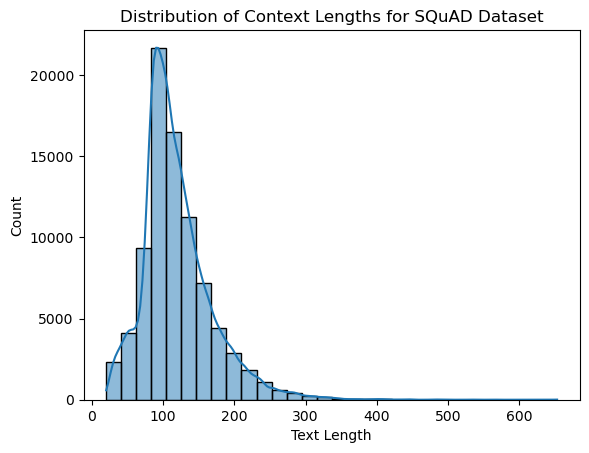

In [19]:
df_news_qa["context_len"] = df_news_qa["context"].apply(lambda x: len(x.split()))
print("mean context length",df_news_qa["context_len"].mean())
print("meadian context length",df_news_qa["context_len"].median())

sns.histplot(df_news_qa["context_len"], bins=30, kde=True)
plt.title('Distribution of Context Lengths for News Dataset')
plt.xlabel('Text Length')
plt.show()

df_squad_select["context_len"] = df_squad_select["context"].apply(lambda x: len(x.split()))
print("mean context length",df_squad_select["context_len"].mean())
print("meadian context length",df_squad_select["context_len"].median())

sns.histplot(df_squad_select["context_len"], bins=30, kde=True)
plt.title('Distribution of Context Lengths for SQuAD Dataset')
plt.xlabel('Text Length')
plt.show()


Due to significant disparities in context, longer contexts in the SQuAD dataset are prioritized for use.

mean question length 10.833333333333334
meadian question length 9.0


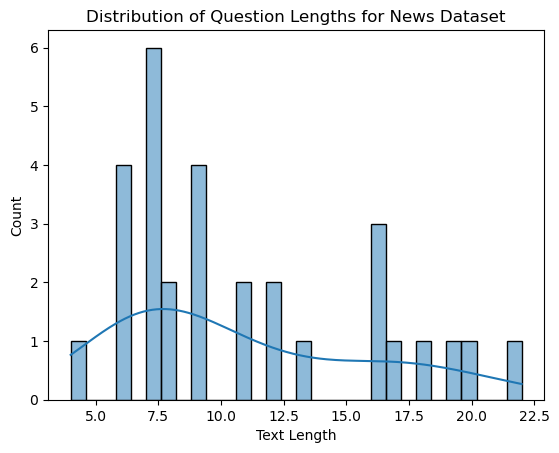

mean question length 10.063878851274248
meadian question length 10.0


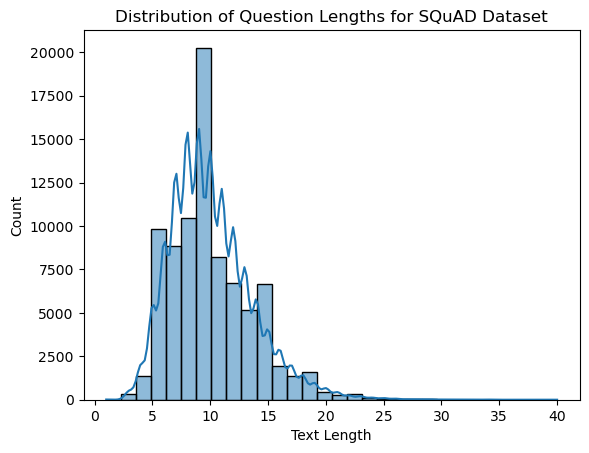

In [20]:
df_news_qa["question_len"] = df_news_qa["question"].apply(lambda x: len(x.split()))
print("mean question length",df_news_qa["question_len"].mean())
print("meadian question length",df_news_qa["question_len"].median())

sns.histplot(df_news_qa["question_len"], bins=30, kde=True)
plt.title('Distribution of Question Lengths for News Dataset')
plt.xlabel('Text Length')
plt.show()

df_squad_select["question_len"] = df_squad_select["question"].apply(lambda x: len(x.split()))
print("mean question length",df_squad_select["question_len"].mean())
print("meadian question length",df_squad_select["question_len"].median())

sns.histplot(df_squad_select["question_len"], bins=30, kde=True)
plt.title('Distribution of Question Lengths for SQuAD Dataset')
plt.xlabel('Text Length')
plt.show()


The length of the questions does not differ significantly between the news dataset and the SQuAD dataset.

mean answer length 8.733333333333333
meadian answer length 7.0


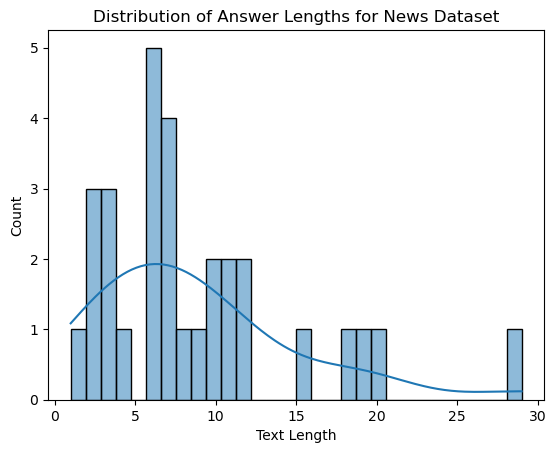

mean answer length 2.8794574933434767
meadian answer length 2.0


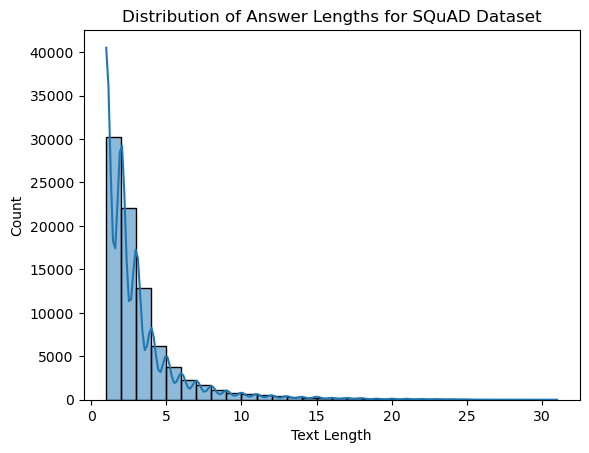

In [21]:
df_news_qa["answer_len"] = df_news_qa["answer_text"].apply(lambda x: len(x.split()))
print("mean answer length",df_news_qa["answer_len"].mean())
print("meadian answer length",df_news_qa["answer_len"].median())

sns.histplot(df_news_qa["answer_len"], bins=30, kde=True)
plt.title('Distribution of Answer Lengths for News Dataset')
plt.xlabel('Text Length')
plt.show()

df_squad_select["answer_len"] = df_squad_select["answer_text"].apply(lambda x: len(x.split()))
print("mean answer length",df_squad_select["answer_len"].mean())
print("meadian answer length",df_squad_select["answer_len"].median())

sns.histplot(df_squad_select["answer_len"], bins=30, kde=True)
plt.title('Distribution of Answer Lengths for SQuAD Dataset')
plt.xlabel('Text Length')
plt.show()


It can be confirmed that there is a significant difference in the length of answers between the news dataset and the SQuAD dataset. This is because the news dataset mainly consists of sentence-based answers, whereas the SQuAD dataset consists of word or phrase-based answers, leading to the disparity.

### 2.3. Analyse Initial Place Names

In [22]:
nlp_coref = spacy.load("en_core_web_trf")

In [23]:
def header_place_checker(text):
    
    doc = nlp(text)
    if len(doc.ents)==0:
        return None

    else:
        header_word = text.split()[0]
        if doc.ents[0].text == header_word:

            return doc.ents[0].label_
        else:
            return None

def is_header_uppercase(text):
    header_word = text.split()[0]
    if header_word.isupper():
        return "1"
    else:
        return "0"

In [ ]:
# News dataset

In [24]:
df_news_qa["ent_label"] = df_news_qa["context"].apply(lambda x: header_place_checker(x))
df_news_qa["header_upper_flg"] = df_news_qa["context"].apply(lambda x: is_header_uppercase(x))

In [26]:
df_news_qa[(df_news_qa["header_upper_flg"]=="1")&
                  (df_news_qa["ent_label"].notnull())
                 ][["ent_label","context"]]

,ent_label,context
1,GPE,"HOUSTON ? There was the game on the field, ..."
5,GPE,MOSCOW ? All died far from the front lines ...
7,GPE,WASHINGTON ? The chiefs of America?s intell...
11,GPE,WASHINGTON ? The Trump administration is pr...
12,ORG,"MODERN homes today are getting light bulbs, ..."
15,ORG,ISTANBUL ? Turkish officials accused the Un...
18,ORG,OTTAWA ? It was 7 a. m. and 99 passengers a...
26,GPE,WASHINGTON ? It was supposed to be a triump...
27,GPE,WASHINGTON ? Smartphone users in Russia can...


It is evindent that the beginning of some news dataset starts with with a place name.
In named entity recognition (NER), it can be confirmed that the place names at the beginning of articles are classified as 'GPE' (Geo-Political Entity) and 'ORG' (Organization).
The initial place names are considered to have no relevance to the question and answer, and thus, they are excluded.

In [ ]:
# SQuAD dataset

In [27]:
df_squad_select["ent_label"] = df_squad_select["context"].apply(lambda x: header_place_checker(x))
df_squad_select["header_upper_flg"] = df_squad_select["context"].apply(lambda x: is_header_uppercase(x))

In [178]:
df_squad_select[(df_squad_select["header_upper_flg"]=="1")&
                   (df_squad_select["ent_label"].notnull())
                  ][["ent_label","context"]].drop_duplicates()

,ent_label,context
2516,ORG,BMW released the first iPod automobile interfa...
8806,ORG,CDO issuance grew from an estimated $20 billio...
9553,ORG,EPN is known for research and education in the...
9559,ORG,MIT raises funds from non-governmental organiz...
10906,ORG,"BBC Japan was a general entertainment channel,..."
...,...,...
73323,ORG,"IBM also had their own DBMS in 1966, known as ..."
73357,ORG,IBM started working on a prototype system loos...
73370,ORG,\nXML databases are a type of structured docum...
75274,GPE,"U.S. submarines, as well as some British and D..."


It is evident that place names in the SQuAD dataset are less likely to appear at the beginning of articles.

### 2.4. Analyse Pronoun Proportion 

In [29]:
def count_pronouns(text):
    doc = nlp(text)
    pronoun_count = sum(1 for token in doc if token.pos_ == "PRON")
    return pronoun_count


In [30]:
df_news_qa["cnt_pron"] = df_news_qa["context"].apply(lambda x: count_pronouns(x))
df_news_qa["cnt_words"] = df_news_qa["context"].apply(lambda x: len(x.split()))
df_news_qa["pron_rate"] = df_news_qa["cnt_pron"]/df_news_qa["cnt_words"]

mean 0.06391417537567784
median 0.0563121443649289


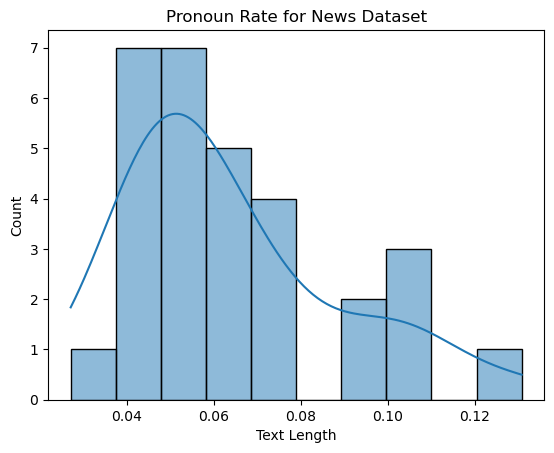

In [31]:
print("mean",df_news_qa["pron_rate"].mean())
print("median",df_news_qa["pron_rate"].median())

sns.histplot(df_news_qa["pron_rate"], bins=10, kde=True)
plt.title('Pronoun Rate for News Dataset')
plt.xlabel('Text Length')
plt.show()


In [32]:
df_squad_select["cnt_pron"] = df_squad_select["context"].apply(lambda x: count_pronouns(x))
df_squad_select["cnt_words"] = df_squad_select["context"].apply(lambda x: len(x.split()))
df_squad_select["pron_rate"] = df_squad_select["cnt_pron"]/df_squad_select["cnt_words"]

mean 0.0316841546767274
median 0.0273224043715847


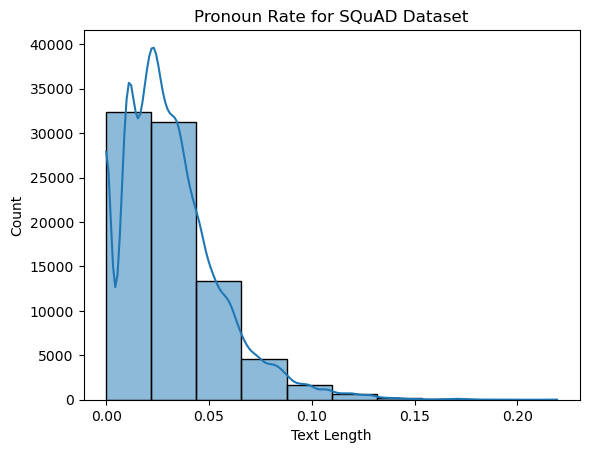

In [33]:
print("mean",df_squad_select["pron_rate"].mean())
print("median",df_squad_select["pron_rate"].median())


sns.histplot(df_squad_select["pron_rate"], bins=10, kde=True)
plt.title('Pronoun Rate for SQuAD Dataset')
plt.xlabel('Text Length')
plt.show()


It can be confirmed that the proportion of pronouns is higher in the news dataset compared to the SQuAD dataset. When coreference resolution is performed, it can be anticipated that the accuracy would be more affected in the news dataset.
Given the potential difficulties in interpreting sentences due to pronouns, coreference resolution is employed to address the challenges associated with pronouns.

### 2.5. Comparison between original articles and samples from the news dataset.

In [37]:
print("★★sample news1 - dataset★★")
display(df_news_qa["context"][0])

★★sample news1 - dataset★★


'At least six members of the Super   New England Patriots have said they will not visit the White House for the traditional meeting that championship teams have with the president. Running back LeGarrette Blount, defensive end Chris Long and defensive tackle Alan Branch on Thursday became the latest to announce that they would skip the visit. Long posted on Twitter that he ?planned on skipping? in response to a column in The Daily News that urged him to skip. Blount revealed his decision on Fox Sports in a radio interview on ?The Rich Eisen Show? later in the afternoon. ?I just don?t feel welcome in that house,? Blount said. ?I?m going to just leave it at that. ? Branch told Sirius XM Radio that he planned to spend time with family. A day earlier, the Pro Bowl linebacker Dont?a Hightower bowed out when he told ESPN, ?Been there, done that,? having visited with a championship Alabama team. Tight end Martellus Bennett told reporters after the Super Bowl that he would not go: ?It is what 

★★sample news1 - original sentence★★   
https://www.nytimes.com/2017/02/08/sports/football/new-england-patriots-white-house-visit-donald-trump.html

At least six members of the Super Bowl-winning New England Patriots have said they will not visit the White House for the traditional meeting that championship teams have with the president. Running back LeGarrette Blount, defensive end Chris Long and defensive tackle Alan Branch on Thursday became the latest to announce that they would skip the visit. Long posted on Twitter that he “planned on skipping” in response to a column in The Daily News that urged him to skip. Blount revealed his decision on Fox Sports in a radio interview on “The Rich Eisen Show” later in the afternoon. “I just don’t feel welcome in that house,” Blount said. “I’m going to just leave it at that.” Branch told Sirius XM Radio that he planned to spend time with family. A day earlier, the Pro Bowl linebacker Dont’a Hightower bowed out when he told ESPN, “Been there, done that,” having visited with a championship Alabama team. Tight end Martellus Bennett told reporters after the Super Bowl that he would not go: “It is what it is,” he said. “People know how I feel about it. Just follow me on Twitter.” The outspoken Bennett had joked that he might move to outer space after Donald J. Trump was elected. The Pro Bowl safety Devin McCourty, a team captain, told Time magazine: “Basic reason for me is I don’t feel accepted in the White House. With the president having so many strong opinions and prejudices, I believe certain people might feel accepted there while others won’t.” Bennett and McCourty were in the news for their activism last fall, when they raised their fists in protest during the national anthem for one game. At the time, athletes in various sports were protesting racial oppression in the country. The number of Patriots absences may well increase. Running back James White said he had not made up his mind whether to go. “I’ll wait till the time comes and decide then,” he said. No date has been scheduled for this year’s ceremony honoring the Patriots. The ceremony for last year’s champions, the Broncos, took place in June. Perhaps no other team has as close an association with Trump as the Patriots. Just before the election, Trump claimed that he had the support of Patriots quarterback Tom Brady and Coach Bill Belichick. Brady, who displayed a “Make America Great Again” cap in his locker during the campaign, never explicitly endorsed Trump, but he spoke favorably of him and they have socialized. Trump also cited a supportive letter he had received from Belichick, and several news media accounts confirmed the letter was authentic. The team’s owner, Robert K. Kraft, has said he has considered Trump a longtime friend. Brady did not attend his team’s visit with former President Barack Obama at the White House, in 2015, citing family issues. But some athletes who have skipped the trip over the years have explicitly given politics as a reason. Bruins goalie Tim Thomas declined to visit the Obama White House with his teammates in January 2012, saying in a statement: “I believe the federal government has grown out of control, threatening the rights, liberties and property of the people. Because I believe this, today I exercised my right as a free citizen, and did not visit the White House.” Baltimore Ravens center Matt Birk cited his opposition to abortion as the reason for skipping a 2013 visit. A number of other athletes have skipped the ceremony while citing scheduling conflicts or family commitments. Presidents for years have invited sports figures to the White House, but the tradition of honoring championships teams there solidified under Ronald Reagan. Major professional champions and many college champions stop by for a presentation and a photo opportunity. Six Patriots, so far, won’t make the trip this year.

In [38]:
print("★★sample news2 - dataset★★")
display(df_news_qa["context"][1])

★★sample news2 - dataset★★


'HOUSTON  ?   There was the game on the field, and there was the one watched through the political prism of these times. On social media, the Atlanta Falcons were not just the N. F. C. champions, they were   for   ferment, coming from a staunchly Democratic city and facing a Patriots team whose owner, head coach and starting quarterback are all friends with the president, to varying degrees. ?Falcons are fun and their biggest stars aren?t pro Trump,? JayZito wrote on Twitter. ?I?m a Falcons fan today. ? Not long before the game started, President Trump, in an interview on Fox, which was broadcasting the game, predicted a Patriot win by 8 points in part out of support for his friends. That prediction was the object of ridicule as Atlanta surged ahead, but then it ended up appearing prescient as the Patriots stormed back to win,   in the first Super Bowl overtime. Mr. Trump did not attend the game, opting for a traditional    party near his    vacation home in South Florida. (Social medi

★★sample news2 - original sentence★★   
https://www.nytimes.com/2017/02/06/sports/football/super-bowl-trump-ads-atlanta.html

HOUSTON — There was the game on the field, and there was the one watched through the political prism of these times. On social media, the Atlanta Falcons were not just the N.F.C. champions, they were stand-ins for anti-Trump ferment, coming from a staunchly Democratic city and facing a Patriots team whose owner, head coach and starting quarterback are all friends with the president, to varying degrees. “Falcons are fun and their biggest stars aren’t pro Trump,” JayZito wrote on Twitter. “I’m a Falcons fan today.” Not long before the game started, President Trump, in an interview on Fox, which was broadcasting the game, predicted a Patriot win by 8 points in part out of support for his friends. That prediction was the object of ridicule as Atlanta surged ahead, but then it ended up appearing prescient as the Patriots stormed back to win, 34-28, in the first Super Bowl overtime. Mr. Trump did not attend the game, opting for a traditional Super-Bowl-watching party near his Mar-a-Lago vacation home in South Florida. (Social media users dissected a picture of Mr. Trump and his family not looking enthusiastic at a table there and took sometimes harsh note of Mr. Trump’s departure with nearly an hour and a half left in the game.) Vice President Mike Pence attended the game and drew some boos when he was shown on a stadium screen talking with James Baker, who served as secretary of state under former President George Bush. Mr. Bush did the opening coin toss from a wheelchair on the field, accompanied by the former first lady Barbara Bush. A succession of commercials with themes of inclusion, immigration and multiculturalism were seen by many viewers as commentary on Trump’s executive orders restricting immigration and his calls for a wall along the Mexican border. One commercial made by Anheuser-Busch follows the path of one of the company’s co-founders, Adolphus Busch, as he immigrated from Germany to the United States. The ad was criticized by some right-leaning commentators who created a hashtag, #BoycottBudweiser. The actor Morgan Freeman appeared in a commercial for Turkish Airlines, speaking about “bridging worlds and finding delight in our differences.” Before, during and after the game, people talked about an ad for the construction-supply company 84 Lumber that featured imagery of a Mexican mother and daughter on a journey north for a better life in the United States. The company deleted some scenes depicting a border wall but included the full ad on its website. The right-wing website Breitbart News, in its live coverage of the game, grew exasperated. “These commercials have been a bonanza of leftist activism: two immigration commercials, a feminist commercial, now an eco wacko commercial? Am I missing anything?” one of the editors wrote. About the only aspect of the game that generated a surprisingly more muted political discussion than expected was the one everybody seemed to think would cause a stir: the halftime show by Lady Gaga, a persistent critic of Mr. Trump. With a dash of patriotic imagery — red and blue drones forming the shape of the United States — she mostly stuck to her hits, with only a few gestures that some interpreted as subtle digs at the president. During her song “Million Reasons” she hugged a woman of uncertain ethnicity and sang, “Why don’t you stay,” a move that people on Twitter thought was a statement about race and immigration. The N.F.L. tried in its own way to unify the country for a few hours. Fans at the stadium were given small flags to wave during the singing of the national anthem, and when the teams ran onto the field, they were led by soldiers and sailors holding large American flags. The league even ran a 60-second commercial called “Inside These Lines” to show that “the power of football” can “bring people together.” Still, outside the stadium it was another story. The president’s unabashed support for the Patriots turned into a punch line on social media when the Patriots fell behind by 25 points early in the second half. Some fans accused the president of jinxing the team. In Houston, hundreds of people protested the president and his policies near the stadium, crossing paths with thousands of fans heading to the game. Chants of “Black Lives Matter” were applauded by Falcons fans. Similar protests took place last week near an N.F.L.-themed park downtown. Atlanta, the capital of a solidly red state, was suddenly adopted as a darling of left-leaning football fans. One commenter on Twitter joked, “The Falcons respect an independent judiciary,” a dig at the president’s criticism of the federal judge in Seattle who temporarily halted the refugee ban. Some Patriots fans, uneasy with their team’s link to the president, encouraged fellow fans to donate to organizations like the N.A.A.C.P. and Planned Parenthood each time the Patriots scored. After the game, Martellus Bennett, a tight end for the Patriots, reiterated his vow not to attend the customary congratulatory ceremony at the White House, because he opposes Mr. Trump. Still, at the end Mr. Trump exulted, once again stoking support and derision. “What an amazing comeback and win by the Patriots,’’ he wrote on Twitter. “Tom Brady, Bob Kraft and Coach B are total winners. Wow!”

It can be confirmed that single quotation marks, double quotation marks, dashes, etc., are being converted to question marks.

In preprocessing, the following actions are taken:
- Single quotation marks → Apostrophes like 'xxx's' need to be complemented.
- Double quotation marks → Excluded.
- Dashes → Excluded.

Additionally, there are spaces and periods between each character of acronyms. To recognize them as a single acronym during tokenization, the spaces and periods between acronyms are excluded.

For the SQuAD dataset, only sample in the dataset is displayed. It don't seem to be any issues in the samples.

In [36]:
print("★★sample SQuAD1★★")
display(df_squad_select["context"][0])

print("---------------------")
print("★★sample SQuAD2★★")
display(df_squad_select["context"][1])


★★sample SQuAD1★★


'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

---------------------
★★sample SQuAD2★★


'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

### 2.6. Key findings for subsequent preprocessing


- Imputation of missing values is unnecessary. (According to 2.1)
- Use only context with over 300 words from the SQuAD dataset. (According to 2.2)
- Exclude initial place names from the news dataset. (According to 2.3)
- Replace pronouns through Coreference Resolution. (According to 2.4)
- Tidy question marks. (According to 2.5)
- Exclude period and space from acronym. (According to 2.5)

### 3. Preprocessing

### 3.1. Exclude data point where the word length is less than or equal to 300 from the SQuAD dataset

In [41]:
df_squad_prep = df_squad_select.copy()[df_squad_select["context_len"]>300]
df_squad_prep.shape

(537, 15)

### 3.2. Exclude initial place names from the news dataset

In [42]:
cnt_remove_place=0
def remove_place_header(text):
    global cnt_remove_place
    if cnt_remove_place % 100 == 0:
        print("count",cnt_remove_place)
    cnt_remove_place+=1

    doc_ner = nlp(text)

    # Exclude consecutive geographical names at the beginning. For example, exclude "SEOUL, South Korea". 
    if (doc_ner.ents[0].label_ in ["ORG","GPE"]) and (doc_ner.ents[1].label_ in ["ORG","GPE"]):
        text = re.sub(f'^({doc_ner.ents[0]}|{doc_ner.ents[1]}|[\s\,\. ])+\? +', "",text)

    # Exclude standalone geographical names at the beginning. For example, exclude "SEOUL".
    if doc_ner.ents[0].label_ in ["ORG","GPE"]:
        text = re.sub(f'^({doc_ner.ents[0]}|[\s\,\. ])+\? +', "",text)

    return text

In [43]:
df_news_qa_prep = df_news_qa.copy()
df_news_qa_prep["context"] = df_news_qa_prep["context"].apply(lambda x: remove_place_header(x))

count 0


### 3.3. Tidy Question Mark

In [44]:
cnt_clean_question_mark=0
def clean_question_mark(text):
    global cnt_clean_question_mark
    if cnt_clean_question_mark % 100 == 0:
        print("count",cnt_clean_question_mark)
    cnt_clean_question_mark+=1

    text = re.sub("I\?m","I'm",text)
    text = re.sub("n\?t","n't",text)
    text = re.sub("([A-Za-z])\?(s|re|ve|ll|d)","\\1'\\2",text)
    text = text.replace("?","")
    
    return text

In [45]:
df_news_qa_prep["context"] = df_news_qa_prep["context"].apply(lambda x: clean_question_mark(x))

count 0


### 3.4 Exclude Period and Space from acronym

In [46]:
cnt_tidy_acronym=0
def tidy_acronym(text):
    global cnt_tidy_acronym
    if cnt_tidy_acronym % 100 == 0:
        print("count",cnt_tidy_acronym)
    cnt_tidy_acronym+=1
    # Tidy acronym
    while re.search("([A-Z]\. ){2,}",text):
        
        match = re.search(r'([A-Z]\. ){2,}', text).group()
        match_rep = match.replace(" ","")
        match_rep = match_rep + " "
        text = text.replace(match,match_rep)
    
    return text

In [47]:
df_news_qa_prep["context"] = df_news_qa_prep["context"].apply(lambda x: tidy_acronym(x))

count 0


In [48]:
df_squad_prep["context"] = df_squad_prep["context"].apply(lambda x: tidy_acronym(x))

count 100
count 200
count 300
count 400
count 500


### 3.5. Replace pronouns through Coreference Resolution

To assess the effectiveness of Coreference Resolution, datasets with and without coreference resolution is created.

In [49]:
nlp_coref = spacy.load("en_core_web_trf")
nlp_coref_source = spacy.load("en_coreference_web_trf")

nlp_coref_source.replace_listeners("transformer", "coref", ["model.tok2vec"])
nlp_coref_source.replace_listeners("transformer", "span_resolver", ["model.tok2vec"])

nlp_coref.add_pipe("coref", source=nlp_coref_source)
nlp_coref.add_pipe("span_resolver", source=nlp_coref_source)


In [50]:
cnt_coref_resolution=0

def coref_resolution(text):
    global cnt_coref_resolution
    print("count",cnt_coref_resolution)
    cnt_coref_resolution+=1

    doc = nlp_coref(text)
    coref_enti = [str(token) for token in doc]
    coref_clusters = {key : val for key , val in doc.spans.items() if re.match(r"coref_clusters_*",key)}
    coref_w_spans = find_span_start_end(coref_clusters)
    coref_clusters_with_name_spans = find_person_start_end(coref_clusters,coref_w_spans)
    tokens = replace_refs_w_names(coref_clusters_with_name_spans, coref_enti)
    return_text = tidy_text(" ".join(tokens))
    text = " ".join(tokens)

    return return_text

def find_span_start_end(coref_clusters):

    cluster_w_spans = {}
    for cluster in coref_clusters:
        cluster_w_spans[cluster] = [(span.start, span.end, span.text) for span in coref_clusters[cluster]]

    return cluster_w_spans

def find_person_start_end(coref_clusters,cluster_w_spans):
    coref_clusters_with_name_spans = {}
    for key, val in coref_clusters.items():
        temp = [0 for i in range(len(val))]
        person_flag = False
        for idx, text in enumerate(val):
            doc = nlp_coref(str(text))
            for word in doc.ents:
                if word.label_ == 'PERSON':
                    temp[idx] = (word.start, word.end, word.text)
                    person_flag = True
            for token in doc:
                if token.pos_ == 'PRON':
                    temp[idx] = (token.i,token.i+1,token)
        if len(temp) > 0:
            if person_flag:
                orig = cluster_w_spans[key]
                for idx, tup in enumerate(orig):
                    if isinstance(tup, tuple) and isinstance(temp[idx], tuple):
                        orig_start, orig_end, text = tup
                        offset_start, offset_end, _ = temp[idx]
                        orig_start += offset_start
                        orig_end = orig_start + (offset_end - offset_start) 
                        orig[idx] = (orig_start, orig_end, text)
                coref_clusters_with_name_spans[key] = orig

    return coref_clusters_with_name_spans

def replace_refs_w_names(coref_clusters_with_name_spans, tokens):
    special_tokens = ["my","his","her","mine"]
    for key, val in coref_clusters_with_name_spans.items():
        if len(val) > 0 and isinstance(val, list):
            head = val[0]
            head_start, head_end, _ = head
            head_name = " ".join(tokens[head_start:head_end])
            for i in range(1,len(val)):
                coref_token_start, coref_token_end, _ = val[i]
                count = 0
                for j in range(coref_token_start, coref_token_end):
                    if tokens[j].upper() == "I":
                        count += 1
                        continue
                    if count == 0:
                        if tokens[j].lower() in special_tokens:
                            if head_name[-1].lower() == "s":
                                tokens[j] = str(head_name)+"'"
                            else:
                                tokens[j] = str(head_name)+"'s"
                        else:
                            tokens[j] = head_name
                    else:
                        tokens[j] = ""
                    count += 1

    return tokens


def tidy_text(text):
    text = re.sub(" (\.|\,)","\\1",text)
    text = text.replace(" n't","n't")
    text = re.sub(" '(s|re|ve|ll|d|m) ","'\\1 ",text)
    text = re.sub(" +"," ",text)
    return text
    

In [51]:
df_news_qa_prep["context_cr"] = df_news_qa_prep["context"].apply(lambda x:coref_resolution(x))

count 0
count 1
count 2
count 3
count 4
count 5
count 6
count 7
count 8
count 9
count 10
count 11
count 12
count 13
count 14
count 15
count 16
count 17
count 18
count 19
count 20
count 21
count 22
count 23
count 24
count 25
count 26
count 27
count 28
count 29


Multiple occurrences of answer in context through coreference resolution is confirmed below.

In [52]:
df_news_qa_prep["num_answer_words"] = df_news_qa_prep[["context","answer_text"]].apply(lambda x: x[0].count(x[1]),axis=1)
df_news_qa_prep["num_answer_words_cr"] = df_news_qa_prep[["context_cr","answer_text"]].apply(lambda x: x[0].count(x[1]),axis=1)

In [53]:
df_news_qa_prep[df_news_qa_prep["num_answer_words"]!=1].index

Index([], dtype='int64')

In [54]:
df_news_qa_prep[df_news_qa_prep["num_answer_words_cr"]!=1].index

Index([1, 5, 7, 9, 10, 25, 29], dtype='int64')

Answer that is changed through coreference resolution is modified below.

In [55]:
df_news_qa_prep["answer_text_cr"] = df_news_qa_prep["answer_text"]

In [56]:
answer_text_cr = {
1:"Mr. George Bush did the opening coin toss",
7:"Mr. Vladimir V. Putin of Russia",
9:"who were convicted of espionage in 1986",
10:"Berzelius ( Buzz ) Windrip has returned to the United States",
25:"The chaos in Washington, bedlam at airports and protests across the country serve as an unsettling crowd noise to I . I is friends with President Trump.",
29:"Mr. Jos began having violent seizures"
}

In [57]:
for key in answer_text_cr.keys():
    df_news_qa_prep.at[key,"answer_text_cr"] = answer_text_cr[key]

In [58]:
# SQuAD

In [59]:
df_squad_prep["context_cr"] = df_squad_prep["context"].apply(lambda x:coref_resolution(x))

count 30
count 31
count 32
count 33
count 34
count 35
count 36
count 37
count 38
count 39
count 40
count 41
count 42
count 43
count 44
count 45
count 46
count 47
count 48
count 49
count 50
count 51
count 52
count 53
count 54
count 55
count 56
count 57
count 58
count 59
count 60
count 61
count 62
count 63
count 64
count 65
count 66
count 67
count 68
count 69
count 70
count 71
count 72
count 73
count 74
count 75
count 76
count 77
count 78
count 79
count 80
count 81
count 82
count 83
count 84
count 85
count 86
count 87
count 88
count 89
count 90
count 91
count 92
count 93
count 94
count 95
count 96
count 97
count 98
count 99
count 100
count 101
count 102
count 103
count 104
count 105
count 106
count 107
count 108
count 109
count 110
count 111
count 112
count 113
count 114
count 115
count 116
count 117
count 118
count 119
count 120
count 121
count 122
count 123
count 124
count 125
count 126
count 127
count 128
count 129
count 130
count 131
count 132
count 133
count 134
count 135
count 136


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


count 316
count 317
count 318
count 319
count 320
count 321
count 322
count 323
count 324
count 325
count 326
count 327
count 328
count 329
count 330
count 331
count 332
count 333
count 334
count 335
count 336
count 337
count 338
count 339
count 340
count 341
count 342
count 343
count 344
count 345
count 346
count 347
count 348
count 349
count 350
count 351
count 352
count 353
count 354
count 355
count 356
count 357
count 358
count 359
count 360
count 361
count 362
count 363
count 364
count 365
count 366
count 367
count 368
count 369
count 370
count 371
count 372
count 373
count 374
count 375
count 376
count 377
count 378
count 379
count 380
count 381
count 382
count 383
count 384
count 385
count 386
count 387
count 388
count 389
count 390
count 391
count 392
count 393
count 394
count 395
count 396
count 397
count 398
count 399
count 400
count 401
count 402
count 403
count 404
count 405
count 406
count 407
count 408
count 409
count 410
count 411
count 412
count 413
count 414
count 415


If coreference resolution has resulted in multiple occurrences of the answer, the news dataset is adjusted accordingly. However, since the SQuAD dataset has more data points than the news dataset, it will be excluded.

In [60]:
df_squad_prep["num_answer_words"] = df_squad_prep[["context","answer_text"]].apply(lambda x: x[0].count(x[1]),axis=1)
df_squad_prep["num_answer_words_cr"] = df_squad_prep[["context_cr","answer_text"]].apply(lambda x: x[0].count(x[1]),axis=1)

df_squad_prep_resample = df_squad_prep.copy()[(df_squad_prep["num_answer_words"]==1)&(df_squad_prep["num_answer_words_cr"]==1)]

The pretrained BERT model to be used in this case has a token limit of 512. Therefore, any data point exceeding this limit will be excluded.

In [61]:
df_squad_prep_resample["len_token"] = df_squad_prep_resample[["context","question"]].apply(lambda x: len(tokenizer_ori.encode(x[0],x[1])),axis=1)
df_squad_prep_resample["len_token_cr"] = df_squad_prep_resample[["context_cr","question"]].apply(lambda x: len(tokenizer_ori.encode(x[0],x[1])),axis=1)
df_squad_prep_resample = df_squad_prep_resample[(df_squad_prep_resample["len_token"]<512)&
                                                (df_squad_prep_resample["len_token_cr"]<512)]
df_squad_prep_resample.reset_index(inplace=True,drop=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors


### 3.6. Train Test Split

For both the news dataset and the SQuAD dataset, they will be divided into training and test datasets. However, during the consideration of candidate approaches, the training dataset will be further divided into training data and validation data.
The number of data entries during the consideration of candidate approaches and the construction of the final model is as follows:

- Consideration of candidate approaches
|                   | News | SQuAD |
|-------------------|------|-------|
| # of training data      |  10  |  151  |
| # of validation data    |  10  |   51  |


- Construction of the final model
|                   | News | SQuAD |
|-------------------|------|-------|
| # of training data      |  20  |  202  |
| # of test data          |  10  |   50  |

In [63]:
# news

In [111]:
col_news = ["id","question","context","context_cr","answer_text","answer_text_cr"]
df_news_train_ori = df_news_qa_prep.copy()[0:20][col_news]
df_news_test_ori = df_news_qa_prep.copy()[20:30][col_news]
valid_news_ids = df_news_train_ori.loc[10:20,"id"].to_list()

In [113]:
df_news_train_ori["len_token"] = df_news_train_ori[["context","question"]].apply(lambda x: len(tokenizer_ori.encode(x[0],x[1])),axis=1)
df_news_test_ori["len_token"] = df_news_test_ori[["context","question"]].apply(lambda x: len(tokenizer_ori.encode(x[0],x[1])),axis=1)

df_news_train_ori["len_token_cr"] = df_news_train_ori[["context_cr","question"]].apply(lambda x: len(tokenizer_ori.encode(x[0],x[1])),axis=1)
df_news_test_ori["len_token_cr"] = df_news_test_ori[["context_cr","question"]].apply(lambda x: len(tokenizer_ori.encode(x[0],x[1])),axis=1)


In [114]:
def split_context(df_qa,col_nms):
    max_bert_pos = 512 -100
    
    id_nm = col_nms[0]
    len_token_nm = col_nms[1]
    context_nm = col_nms[2]
    question_nm = col_nms[3]
    answer_text_nm = col_nms[4]
    
    df_qa["split_num"] = df_qa[len_token_nm].apply(lambda x: math.ceil(x/max_bert_pos))

    df_split_context = pd.DataFrame()
    for ind in df_qa.index:
        
        len_split = len(df_qa.loc[ind,context_nm].split())//df_qa.loc[ind,"split_num"]
        tmp_lis=[]
        for i in range(df_qa.loc[ind,"split_num"]):
            tmp_lis.append(" ".join(df_qa.loc[ind,context_nm].split()[len_split*i:len_split*(i+1)]))

        for i in range(len(tmp_lis)):
            df_tmp = pd.DataFrame({"id":df_qa.loc[ind,id_nm],
                                   "context":[tmp_lis[i]],
                                   "question":[df_qa.loc[ind,question_nm]],
                                   "answer_text":[df_qa.loc[ind,answer_text_nm]],
                                  })
            df_split_context = pd.concat([df_split_context,df_tmp])
    df_split_context.reset_index(drop=True,inplace=True)
    return df_split_context


In [115]:
df_news_train = split_context(df_news_train_ori,["id","len_token","context","question","answer_text"])
df_news_test = split_context(df_news_test_ori,["id","len_token","context","question","answer_text"])

df_news_train_cr = split_context(df_news_train_ori,["id","len_token_cr","context_cr","question","answer_text_cr"])
df_news_test_cr = split_context(df_news_test_ori,["id","len_token_cr","context_cr","question","answer_text_cr"])


In [72]:
# SQuAD

In [149]:
squad_train_num = round(df_squad_prep_resample.shape[0]*0.8)
squad_valid_num = round(df_squad_prep_resample.shape[0]*0.6)

In [150]:
col_squad=["id","question","context","answer_text"]
df_squad_train = df_squad_prep_resample.copy()[0:squad_train_num][col_squad]
df_squad_test = df_squad_prep_resample.copy()[squad_train_num:][col_squad]

col_squad_cr=["id","question","context_cr","answer_text"]
df_squad_train_cr = df_squad_prep_resample.copy()[0:squad_train_num][col_squad_cr]
df_squad_test_cr = df_squad_prep_resample.copy()[squad_train_num:][col_squad_cr]

df_squad_train_cr.rename(columns={"context_cr":"context"},inplace=True)
df_squad_test_cr.rename(columns={"context_cr":"context"},inplace=True)

In [151]:

df_squad_train["valid_flg"] = False
df_squad_train.loc[squad_valid_num:squad_train_num,"valid_flg"] = True
valid_squad_flg= df_squad_train["valid_flg"]
df_squad_train.drop(columns="valid_flg",inplace=True)

### 3.7. Search for start position

In [77]:
# news

In [100]:
def start_pos_find(df,col_nms=["context","answer_text"]):
    
    context_nm = col_nms[0]
    answer_text_nm = col_nms[1]
    
    answer_start_pos_lis=[]
    for ind in df.index:
        if df[answer_text_nm][ind] in df[context_nm][ind]:
            answer_start_pos_lis.append(df[context_nm][ind].index(df[answer_text_nm][ind]))
        else:
            answer_start_pos_lis.append(None)
    return answer_start_pos_lis

In [116]:
df_news_train["answer_start_position"] = start_pos_find(df_news_train,["context","answer_text"])
df_news_test["answer_start_position"] = start_pos_find(df_news_test,["context","answer_text"])

df_news_train_cr["answer_start_position"] = start_pos_find(df_news_train_cr,["context","answer_text"])
df_news_test_cr["answer_start_position"] = start_pos_find(df_news_test_cr,["context","answer_text"])

In [118]:
print("no_ans_pos_train",len(df_news_train[~df_news_train["answer_start_position"].isnull()]))
print("no_ans_pos_test",len(df_news_test[~df_news_test["answer_start_position"].isnull()]))
print("no_ans_pos_train_cr",len(df_news_train_cr[~df_news_train_cr["answer_start_position"].isnull()]))
print("no_ans_pos_train_cr",len(df_news_test_cr[~df_news_test_cr["answer_start_position"].isnull()]))


print("-------")
# In cases where there are multiple answers, one of them will be excluded.
ex_ind = df_news_train_cr[df_news_train_cr["answer_text"]=="Aleksandr Motuzyanik"].index[-1]
df_news_train_cr.drop(ex_ind,inplace=True)
df_news_train_cr.reset_index(drop=True,inplace=True)
print("no_ans_pos_train_cr",len(df_news_train_cr[~df_news_train_cr["answer_start_position"].isnull()]))


no_ans_pos_train 20
no_ans_pos_test 10
no_ans_pos_train_cr 21
no_ans_pos_train_cr 10
-------
no_ans_pos_train_cr 20


In [94]:
# SQuAD

In [152]:
df_squad_train["answer_start_position"] = start_pos_find(df_squad_train,["context","answer_text"])
df_squad_test["answer_start_position"] = start_pos_find(df_squad_test,["context","answer_text"])

df_squad_train_cr["answer_start_position"] = start_pos_find(df_squad_train_cr,["context","answer_text"])
df_squad_test_cr["answer_start_position"] = start_pos_find(df_squad_test_cr,["context","answer_text"])

In [153]:
print("no_ans_pos_train",len(df_squad_train[~df_squad_train["answer_start_position"].isnull()]))
print("no_ans_pos_test",len(df_squad_test[~df_squad_test["answer_start_position"].isnull()]))
print("no_ans_pos_train_cr",len(df_squad_train_cr[~df_squad_train_cr["answer_start_position"].isnull()]))
print("no_ans_pos_test_cr",len(df_squad_test_cr[~df_squad_test_cr["answer_start_position"].isnull()]))


no_ans_pos_train 202
no_ans_pos_test 50
no_ans_pos_train_cr 202
no_ans_pos_test_cr 50


### 4. Selecting method

In the evaluation of candidate methods, the predictive accuracy of four cases regarding effectiveness of fine-tuning and correference resolution is assessed.


| No | Fine-tuning | Coreference Resolution |
|----|-------------|------------------------|
| 1  | None        | None                   |
| 2  | None        | Yes                    |
| 3  | Yes         | None                   |
| 4  | Yes         | Yes                    |

In [104]:
def get_prediction(model, tokenizer,question, context):

    inputs = tokenizer.encode_plus(question, context, return_tensors='pt')

    outputs = model(**inputs)
    answer_start = torch.argmax(outputs[0])  
    answer_end = torch.argmax(outputs[1]) + 1 
    
    start_score = float(torch.max(outputs[0]))
    end_score = float(torch.max(outputs[0]))
    
    mean_score = (start_score + end_score)/2
    
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

    return answer,mean_score


In [105]:
def normalize_text(s):
   

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def eval_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def eval_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)


### 4.1. None Fine-tuning and None Coreference Resolution

In [138]:
# News
df_news_valid = df_news_train[df_news_train["id"].isin(valid_news_ids)] 
pred_val_news = df_news_valid[["question","context"]].apply(lambda x: get_prediction(model_ori,tokenizer_ori,x[0],x[1]),axis=1)
df_news_valid["pred_answer"] = pred_val_news.apply(lambda x: x[0])
df_news_valid["pred_score"] = pred_val_news.apply(lambda x: x[1])

df_news_valid_comp = df_news_valid.copy()
df_news_valid_comp["pred_score_agg"] = np.where(df_news_valid_comp["pred_answer"]=="[CLS]",-100,df_news_valid_comp["pred_score"])
df_news_valid_comp = df_news_valid_comp.loc[df_news_valid_comp.groupby(['id'])['pred_score_agg'].idxmax()]

df_news_valid_comp["exact_match"] = df_news_valid_comp[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_news_valid_comp["f1"] = df_news_valid_comp[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_news_valid_comp["exact_match"].mean())
print("mean_f1",df_news_valid_comp["f1"].mean())

mean_exact_match 0.2
mean_f1 0.6352130325814537


In [33]:
# SQuAD
df_squad_valid = df_squad_train[valid_squad_flg].copy()
pred_val_squad = df_squad_valid[["question","context"]].apply(lambda x: get_prediction(model_ori,tokenizer_ori,x[0],x[1]),axis=1)
df_squad_valid["pred_answer"] = pred_val_squad.apply(lambda x: x[0])
df_squad_valid["pred_score"] = pred_val_squad.apply(lambda x: x[1])

df_squad_valid["exact_match"] = df_squad_valid[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_squad_valid["f1"] = df_squad_valid[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_squad_valid["exact_match"].mean())
print("mean_f1",df_squad_valid["f1"].mean())


mean_exact_match 0.8235294117647058
mean_f1 0.8858292566078031


### 4.2. None Fine-tuning and Coreference Resolution

In [136]:
# News
df_news_valid_cr = df_news_train_cr[df_news_train_cr["id"].isin(valid_news_ids)] 
pred_val_news_cr = df_news_valid_cr[["question","context"]].apply(lambda x: get_prediction(model_ori,tokenizer_ori,x[0],x[1]),axis=1)
df_news_valid_cr["pred_answer"] = pred_val_news_cr.apply(lambda x: x[0])
df_news_valid_cr["pred_score"] = pred_val_news_cr.apply(lambda x: x[1])

df_news_valid_comp_cr = df_news_valid_cr.copy()
df_news_valid_comp_cr["pred_score_agg"] = np.where(df_news_valid_comp_cr["pred_answer"]=="[CLS]",-100,df_news_valid_comp_cr["pred_score"])
df_news_valid_comp_cr = df_news_valid_comp_cr.loc[df_news_valid_comp_cr.groupby(['id'])['pred_score_agg'].idxmax()]

df_news_valid_comp_cr["exact_match"] = df_news_valid_comp_cr[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_news_valid_comp_cr["f1"] = df_news_valid_comp_cr[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_news_valid_comp_cr["exact_match"].mean())
print("mean_f1",df_news_valid_comp_cr["f1"].mean())


mean_exact_match 0.3
mean_f1 0.658546365914787


In [34]:
# SQuAD
df_squad_valid_cr = df_squad_train_cr[valid_squad_flg].copy()
pred_val_squad_cr = df_squad_valid_cr[["question","context"]].apply(lambda x: get_prediction(model_ori,tokenizer_ori,x[0],x[1]),axis=1)
df_squad_valid_cr["pred_answer"] = pred_val_squad_cr.apply(lambda x: x[0])
df_squad_valid_cr["pred_score"] = pred_val_squad_cr.apply(lambda x: x[1])

df_squad_valid_cr["exact_match"] = df_squad_valid_cr[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_squad_valid_cr["f1"] = df_squad_valid_cr[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_squad_valid_cr["exact_match"].mean())
print("mean_f1",df_squad_valid_cr["f1"].mean())


mean_exact_match 0.8235294117647058
mean_f1 0.8792933088953849


When utilising coreference resolution, an improvement in predictive accuracy is observed for the news dataset, while a decrease in predictive accuracy is noted for the SQuAD dataset. For the SQuAD dataset, coreference resolution might not work effectively since the SQuAD dataset contains shorter passages compared to the news dataset, plus BERT's attention layer can relate pronouns to their corresponding nouns (Clark et al. 2019, p. 276). On the other hand, for the news dataset, coreference resolution likely contributed to identifying pronouns successfully since the news dataset consists of longer passages and only BERT's attention layer might not be enough to identify the relationship of pronouns.

In [139]:
print("Correct answer length",df_news_valid_comp["answer_text"].apply(lambda x: len(x.split())).mean())
print("Predicted answer length",df_news_valid_comp["pred_answer"].apply(lambda x: len(x.split())).mean())

Correct answer length 6.7
Predicted answer length 3.9


In [140]:
print("Correct answer length",df_news_valid_comp_cr["answer_text"].apply(lambda x: len(x.split())).mean())
print("Predicted answer length",df_news_valid_comp_cr["pred_answer"].apply(lambda x: len(x.split())).mean())

Correct answer length 7.1
Predicted answer length 4.0


In [105]:
print("Correct answer length",df_squad_valid["answer_text"].apply(lambda x: len(x.split())).mean())
print("Predicted answer length",df_squad_valid["pred_answer"].apply(lambda x: len(x.split())).mean())

Correct answer length 3.4313725490196076
Predicted answer length 3.6862745098039214


In [107]:
print("Correct answer length",df_squad_valid_cr["answer_text"].apply(lambda x: len(x.split())).mean())
print("Predicted answer length",df_squad_valid_cr["pred_answer"].apply(lambda x: len(x.split())).mean())

Correct answer length 3.4313725490196076
Predicted answer length 3.627450980392157


### 4.3. Fine-tuning and None Coreference Resolution

In [6]:
class Loader:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def tokenize(self,batch):
        tokenized_batch = self.tokenizer(batch["question"], batch["context"],
        max_length=512,
        padding="max_length",
        truncation=True,
        return_offsets_mapping=True,
        return_token_type_ids=True)


        answer_starts = []
        answer_ends = []


        for i, context in enumerate(batch["context"]):              
            answer_start = batch["answer_start_position"][i]
            answer_end = answer_start + len(batch["answer"][i])   
            answer_starts.append(answer_start)
            answer_ends.append(answer_end)


        tokenized_batch["answer_start"] = answer_starts
        tokenized_batch["answer_end"] = answer_ends


        return tokenized_batch


    def prepare_train_features(self,example):
        start_position = example["input_ids"].index(self.tokenizer.cls_token_id)
        end_position = example["input_ids"].index(self.tokenizer.sep_token_id)


        found_start = False
        found_end = False
        for i, (offset_start, offset_end) in enumerate(example["offset_mapping"]):
            if not found_start and offset_start == example["answer_start"]:
                start_position = i
                found_start = True
            if not found_end and offset_end == example["answer_end"]:
                end_position = i
                found_end = True
            if found_start and found_end:
                break


        if not found_start or not found_end:
            start_position = -1
            end_position = -1


        example["start_positions"] = start_position
        example["end_positions"] = end_position
        return example



    def filter_invalid_examples(self,example):
        return example["start_positions"] != -1 and example["end_positions"] != -1

    def convert_to_tensors(self,example):
        example["input_ids"] = torch.tensor(example["input_ids"], dtype=torch.long)
        example["attention_mask"] = torch.tensor(example["attention_mask"], dtype=torch.long)
        return example



In [7]:
tuning_tokenizer = BertTokenizerFast.from_pretrained("bert-large-cased-whole-word-masking-finetuned-squad")
loader=Loader(tuning_tokenizer)

df_news_train_agg = df_news_train.copy()[~df_news_train["id"].isin(valid_news_ids)]
df_news_train_agg = df_news_train_agg[~df_news_train_agg["answer_start_position"].isnull()]
df_train = pd.concat([df_news_train_agg,df_squad_train[~valid_squad_flg]])
df_train.drop(columns="id",inplace=True)
df_train.rename(columns={"answer_text":"answer"},inplace=True)

dataset = Dataset.from_pandas(df_train)
tokenized_dataset = dataset.map(loader.tokenize, batched=True)
prepared_dataset = tokenized_dataset.map(loader.prepare_train_features, batched=False)
filtered_dataset = prepared_dataset.filter(loader.filter_invalid_examples, batched=False)

train_indices, eval_indices = train_test_split(list(range(len(filtered_dataset))), test_size=0.1, random_state=random_state_val)
train_dataset = filtered_dataset.select(train_indices)
eval_dataset = filtered_dataset.select(eval_indices)
train_dataset = train_dataset.map(loader.convert_to_tensors)
eval_dataset = eval_dataset.map(loader.convert_to_tensors)

dataset_dict = DatasetDict({"train": train_dataset, "eval": eval_dataset})

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

In [8]:
tuning_model = BertForQuestionAnswering.from_pretrained('bert-large-cased-whole-word-masking-finetuned-squad')

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=tuning_model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["eval"],
    data_collator=DefaultDataCollator(),
    tokenizer=tuning_tokenizer,
)
trainer.train()


The following columns in the training set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, answer_start, answer_start_position, offset_mapping, question, answer_end, context, answer. If __index_level_0__, answer_start, answer_start_position, offset_mapping, question, answer_end, context, answer are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
/Users/shosakata/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 144
  Num Epochs = 6
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  T

Epoch,Training Loss,Validation Loss
1,No log,0.325120
2,0.912000,0.329002
3,0.538500,0.327866
4,0.691800,0.329483
5,0.569900,0.332512
6,0.393500,0.352945


The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, answer_start, answer_start_position, offset_mapping, question, answer_end, context, answer. If __index_level_0__, answer_start, answer_start_position, offset_mapping, question, answer_end, context, answer are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 16
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-9
Configuration saved in ./results/checkpoint-9/config.json
Model weights saved in ./results/checkpoint-9/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-9/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-9/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_

TrainOutput(global_step=54, training_loss=0.6067188801588835, metrics={'train_runtime': 6797.0264, 'train_samples_per_second': 0.127, 'train_steps_per_second': 0.008, 'total_flos': 802402841198592.0, 'train_loss': 0.6067188801588835, 'epoch': 6.0})

In [157]:
df_news_valid_tuning = df_news_train[df_news_train["id"].isin(valid_news_ids)] 
pred_val_news = df_news_valid_tuning[["question","context"]].apply(lambda x: get_prediction(tuning_model,tuning_tokenizer,x[0],x[1]),axis=1)
df_news_valid_tuning["pred_answer"] = pred_val_news.apply(lambda x: x[0])
df_news_valid_tuning["pred_score"] = pred_val_news.apply(lambda x: x[1])

df_news_valid_tuning_comp = df_news_valid_tuning.copy()
df_news_valid_tuning_comp["pred_score_agg"] = np.where(df_news_valid_tuning_comp["pred_answer"]=="[CLS]",-100,df_news_valid_tuning_comp["pred_score"])
df_news_valid_tuning_comp = df_news_valid_tuning_comp.loc[df_news_valid_tuning_comp.groupby(['id'])['pred_score_agg'].idxmax()]

df_news_valid_tuning_comp["exact_match"] = df_news_valid_tuning_comp[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_news_valid_tuning_comp["f1"] = df_news_valid_tuning_comp[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_news_valid_tuning_comp["exact_match"].mean())
print("mean_f1",df_news_valid_tuning_comp["f1"].mean())

mean_exact_match 0.2
mean_f1 0.6352130325814537


In [10]:
df_squad_valid_tuning = df_squad_train[valid_squad_flg].copy()
pred_val_squad = df_squad_valid_tuning[["question","context"]].apply(lambda x: get_prediction(tuning_model,tuning_tokenizer,x[0],x[1]),axis=1)
df_squad_valid_tuning["pred_answer"] = pred_val_squad.apply(lambda x: x[0])
df_squad_valid_tuning["pred_score"] = pred_val_squad.apply(lambda x: x[1])

df_squad_valid_tuning["exact_match"] = df_squad_valid_tuning[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_squad_valid_tuning["f1"] = df_squad_valid_tuning[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_squad_valid_tuning["exact_match"].mean())
print("mean_f1",df_squad_valid_tuning["f1"].mean())


mean_exact_match 0.8235294117647058
mean_f1 0.8858292566078031


### 4.4. Fine-tuning and Coreference Resolution

In [12]:
tuning_tokenizer_cr = BertTokenizerFast.from_pretrained("bert-large-cased-whole-word-masking-finetuned-squad")
loader_cr=Loader(tuning_tokenizer_cr)

df_news_train_cr_agg = df_news_train_cr.copy()[~df_news_train_cr["id"].isin(valid_news_ids)]
df_news_train_cr_agg = df_news_train_cr_agg[~df_news_train_cr_agg["answer_start_position"].isnull()]
df_train_cr = pd.concat([df_news_train_cr_agg,df_squad_train[~valid_squad_flg]])

# df_train_cr = pd.concat([df_news_train_cr[~valid_news_flg],df_squad_train_cr[~valid_squad_flg]])
df_train_cr.drop(columns="id",inplace=True)
df_train_cr.rename(columns={"answer_text":"answer"},inplace=True)

dataset = Dataset.from_pandas(df_train_cr)
tokenized_dataset = dataset.map(loader_cr.tokenize, batched=True)
prepared_dataset = tokenized_dataset.map(loader_cr.prepare_train_features, batched=False)
filtered_dataset = prepared_dataset.filter(loader_cr.filter_invalid_examples, batched=False)

train_indices, eval_indices = train_test_split(list(range(len(filtered_dataset))), test_size=0.1, random_state=random_state_val)
train_dataset = filtered_dataset.select(train_indices)
eval_dataset = filtered_dataset.select(eval_indices)
train_dataset = train_dataset.map(loader_cr.convert_to_tensors)
eval_dataset = eval_dataset.map(loader_cr.convert_to_tensors)

dataset_dict_cr = DatasetDict({"train": train_dataset, "eval": eval_dataset})


loading file vocab.txt from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/vocab.txt
loading file tokenizer.json from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/tokenizer_config.json
loading configuration file config.json from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/config.json
Model config BertConfig {
  "_name_or_path": "bert

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

In [13]:
tuning_model_cr = BertForQuestionAnswering.from_pretrained('bert-large-cased-whole-word-masking-finetuned-squad')

trainer = Trainer(
    model=tuning_model_cr,
    args=training_args,
    train_dataset=dataset_dict_cr["train"],
    eval_dataset=dataset_dict_cr["eval"],
    data_collator=DefaultDataCollator(),
    tokenizer=tuning_tokenizer_cr,
)
trainer.train()


loading configuration file config.json from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/config.json
Model config BertConfig {
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996


Epoch,Training Loss,Validation Loss
1,No log,0.369291
2,0.941400,0.371919
3,0.589900,0.373014
4,0.701500,0.377175
5,0.588900,0.382092
6,0.394900,0.402012


The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, answer_start, answer_start_position, offset_mapping, question, answer_end, context, answer. If __index_level_0__, answer_start, answer_start_position, offset_mapping, question, answer_end, context, answer are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 16
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-9
Configuration saved in ./results/checkpoint-9/config.json
Model weights saved in ./results/checkpoint-9/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-9/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-9/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_

TrainOutput(global_step=54, training_loss=0.6244881815380521, metrics={'train_runtime': 6734.6616, 'train_samples_per_second': 0.128, 'train_steps_per_second': 0.008, 'total_flos': 802402841198592.0, 'train_loss': 0.6244881815380521, 'epoch': 6.0})

In [160]:
df_news_valid_tuning_cr = df_news_train_cr.copy()[df_news_train_cr["id"].isin(valid_news_ids)] 
pred_val_news_cr = df_news_valid_tuning_cr[["question","context"]].apply(lambda x: get_prediction(tuning_model_cr,tuning_tokenizer_cr,x[0],x[1]),axis=1)
df_news_valid_tuning_cr["pred_answer"] = pred_val_news_cr.apply(lambda x: x[0])
df_news_valid_tuning_cr["pred_score"] = pred_val_news_cr.apply(lambda x: x[1])

df_news_valid_tuning_comp_cr = df_news_valid_tuning_cr.copy()
df_news_valid_tuning_comp_cr["pred_score_agg"] = np.where(df_news_valid_tuning_comp_cr["pred_answer"]=="[CLS]",-100,df_news_valid_tuning_comp_cr["pred_score"])
df_news_valid_tuning_comp_cr = df_news_valid_tuning_comp_cr.loc[df_news_valid_tuning_comp_cr.groupby(['id'])['pred_score_agg'].idxmax()]

df_news_valid_tuning_comp_cr["exact_match"] = df_news_valid_tuning_comp_cr[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_news_valid_tuning_comp_cr["f1"] = df_news_valid_tuning_comp_cr[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_news_valid_tuning_comp_cr["exact_match"].mean())
print("mean_f1",df_news_valid_tuning_comp_cr["f1"].mean())


mean_exact_match 0.3
mean_f1 0.658546365914787


In [15]:
df_squad_valid_tuning_cr = df_squad_train_cr[valid_squad_flg].copy()
pred_val_squad_cr = df_squad_valid_tuning_cr[["question","context"]].apply(lambda x: get_prediction(tuning_model_cr,tuning_tokenizer_cr,x[0],x[1]),axis=1)
df_squad_valid_tuning_cr["pred_answer"] = pred_val_squad_cr.apply(lambda x: x[0])
df_squad_valid_tuning_cr["pred_score"] = pred_val_squad_cr.apply(lambda x: x[1])

df_squad_valid_tuning_cr["exact_match"] = df_squad_valid_tuning_cr[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_squad_valid_tuning_cr["f1"] = df_squad_valid_tuning_cr[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_squad_valid_tuning_cr["exact_match"].mean())
print("mean_f1",df_squad_valid_tuning_cr["f1"].mean())


mean_exact_match 0.8235294117647058
mean_f1 0.8792933088953849


### 4.5. Evaluate Candidate Methods

In [166]:
list_df=[
"df_news_valid_comp",
"df_news_valid_comp_cr",
"df_news_valid_tuning_comp",
"df_news_valid_tuning_comp_cr",
"df_squad_valid",
"df_squad_valid_cr",
"df_squad_valid_tuning",
"df_squad_valid_tuning_cr"
]
df_eval_valid = pd.DataFrame()

for df_nm in list_df:
    exec(f'df_temp=pd.DataFrame({df_nm}[["exact_match","f1"]].mean()).T')
    exec(f'df_temp.index=[re.sub("(df_|_valid|_comp)","","{df_nm}")]')

    df_eval_valid = pd.concat([df_eval_valid,df_temp])

df_eval_valid = df_eval_valid.reset_index().rename(columns={"index":"model"})

In [167]:
df_eval_valid

,model,exact_match,f1
0,news,0.200000,0.635213
1,news_cr,0.300000,0.658546
2,news_tuning,0.200000,0.635213
3,news_tuning_cr,0.300000,0.658546
4,squad,0.823529,0.885829
5,squad_cr,0.823529,0.879293
6,squad_tuning,0.823529,0.885829
7,squad_tuning_cr,0.823529,0.879293


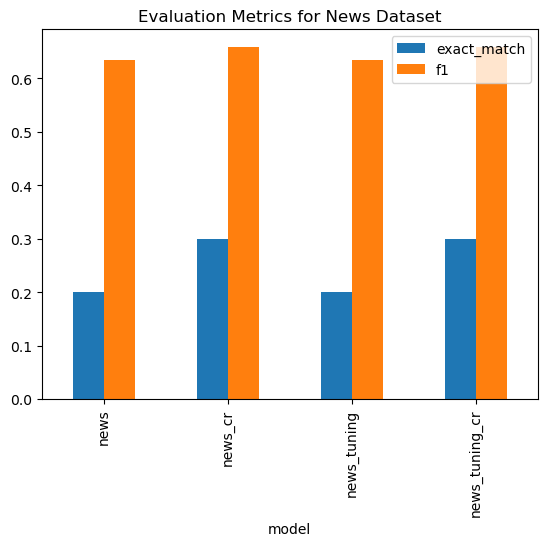

In [168]:
df_eval_valid_news = df_eval_valid[df_eval_valid["model"].str.contains("news")]
df_eval_valid_news.plot(x="model",kind="bar")
plt.title("Evaluation Metrics for News Dataset")
plt.show()

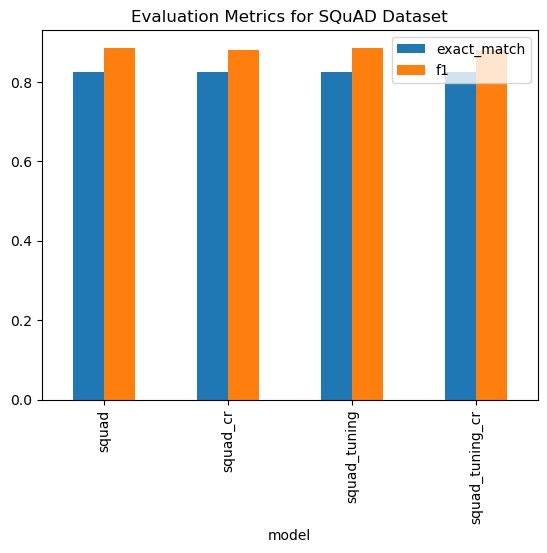

In [169]:
df_eval_valid_news = df_eval_valid[df_eval_valid["model"].str.contains("squad")]
df_eval_valid_news.plot(x="model",kind="bar")
plt.title("Evaluation Metrics for SQuAD Dataset")
plt.show()

| No | fine-tuning | Coreference Resolution | Exact Match (News) | F1 (News) | Exact Match (SQuAD) | F1 (SQuAD) |
|----|-------------|------------------------|---------------------|-----------|----------------------|------------|
| 1  | None        | None                   | 0.300               | 0.735     | 0.824                | 0.886      |
| 2  | None        | Yes                    | 0.400               | 0.759     | 0.824                | 0.879      |
| 3  | Yes         | None                   | 0.300               | 0.735     | 0.824                | 0.886      |
| 4  | Yes         | Yes                    | 0.400               | 0.759     | 0.824                | 0.879      |


The SQuAD dataset was added to supplement the lack of the news dataset. Therefore, prioritizing the F1 score of the News dataset for assessment, options No. 2 or No. 4 would be preferable. While there is no observed improvement in predictive accuracy through fine-tuning, there is also no decrease in predictive accuracy. Additionally, the validation dataset is utilized as part of the training data for the final model, resulting in a larger dataset. This increases the possibility of improved accuracy. Therefore, the approach in No. 4 will be utilised for the final model construction.



### 4.5. Build and Evaluate the Final Model

In [22]:
tuning_tokenizer_final = BertTokenizerFast.from_pretrained("bert-large-cased-whole-word-masking-finetuned-squad")
loader_final=Loader(tuning_tokenizer_final)

df_train_final = pd.concat([df_news_train_cr,df_squad_train_cr])
df_train_final.drop(columns="id",inplace=True)
df_train_final.rename(columns={"answer_text":"answer"},inplace=True)

dataset = Dataset.from_pandas(df_train_final)
tokenized_dataset = dataset.map(loader_final.tokenize, batched=True)
prepared_dataset = tokenized_dataset.map(loader_final.prepare_train_features, batched=False)
filtered_dataset = prepared_dataset.filter(loader_final.filter_invalid_examples, batched=False)

train_indices, eval_indices = train_test_split(list(range(len(filtered_dataset))), test_size=0.1, random_state=random_state_val)
train_dataset = filtered_dataset.select(train_indices)
eval_dataset = filtered_dataset.select(eval_indices)
train_dataset = train_dataset.map(loader_final.convert_to_tensors)
eval_dataset = eval_dataset.map(loader_final.convert_to_tensors)

dataset_dict_final = DatasetDict({"train": train_dataset, "eval": eval_dataset})


loading file vocab.txt from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/vocab.txt
loading file tokenizer.json from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/tokenizer_config.json
loading configuration file config.json from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/config.json
Model config BertConfig {
  "_name_or_path": "bert

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Filter:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

In [23]:
tuning_model_final = BertForQuestionAnswering.from_pretrained('bert-large-cased-whole-word-masking-finetuned-squad')

trainer = Trainer(
    model=tuning_model_final,
    args=training_args,
    train_dataset=dataset_dict_final["train"],
    eval_dataset=dataset_dict_final["eval"],
    data_collator=DefaultDataCollator(),
    tokenizer=tuning_tokenizer_final,
)
trainer.train()


loading configuration file config.json from cache at /Users/shosakata/.cache/huggingface/hub/models--bert-large-cased-whole-word-masking-finetuned-squad/snapshots/de462ace242f74c8c469e35697b4d3a47c77d084/config.json
Model config BertConfig {
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996


Epoch,Training Loss,Validation Loss
1,0.817800,0.763843
2,0.689400,0.742596
3,0.653500,0.731109
4,0.442500,0.719241
5,0.267500,0.737383
6,0.512500,0.722506


The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, answer_start, answer_start_position, offset_mapping, question, answer_end, context, answer. If __index_level_0__, answer_start, answer_start_position, offset_mapping, question, answer_end, context, answer are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 23
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-13
Configuration saved in ./results/checkpoint-13/config.json
Model weights saved in ./results/checkpoint-13/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-13/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-13/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-9] due to args.save_total_limit
The following columns in the evaluation set don't have a correspon

TrainOutput(global_step=78, training_loss=0.5538573891688616, metrics={'train_runtime': 9392.9527, 'train_samples_per_second': 0.126, 'train_steps_per_second': 0.008, 'total_flos': 1103303906648064.0, 'train_loss': 0.5538573891688616, 'epoch': 6.0})

In [26]:
pred_test_news = df_news_test_cr[["question","context"]].apply(lambda x: get_prediction(tuning_model_final,tuning_tokenizer_final,x[0],x[1]),axis=1)
df_news_test_cr["pred_answer"] = pred_test_news.apply(lambda x: x[0])
df_news_test_cr["pred_score"] = pred_test_news.apply(lambda x: x[1])

df_news_test_comp_cr = df_news_test_cr.copy().loc[df_news_test_cr.groupby(['id'])['pred_score'].idxmax()]

df_news_test_comp_cr["exact_match"] = df_news_test_comp_cr[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_news_test_comp_cr["f1"] = df_news_test_comp_cr[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_news_test_comp_cr["exact_match"].mean())
print("mean_f1",df_news_test_comp_cr["f1"].mean())

mean_exact_match 0.5
mean_f1 0.7779144385026739


In [27]:
pred_test_squad = df_squad_test_cr[["question","context"]].apply(lambda x: get_prediction(tuning_model_final,tuning_tokenizer_final,x[0],x[1]),axis=1)
df_squad_test_cr["pred_answer"] = pred_test_squad.apply(lambda x: x[0])
df_squad_test_cr["pred_score"] = pred_test_squad.apply(lambda x: x[1])

df_squad_test_cr["exact_match"] = df_squad_test_cr[["pred_answer","answer_text"]].apply(lambda x: eval_exact_match(x[0], x[1]),axis=1)
df_squad_test_cr["f1"] = df_squad_test_cr[["pred_answer","answer_text"]].apply(lambda x: eval_f1(x[0], x[1]),axis=1)
print("mean_exact_match",df_squad_test_cr["exact_match"].mean())
print("mean_f1",df_squad_test_cr["f1"].mean())


mean_exact_match 0.78
mean_f1 0.9052990342990342


Even though the EM score of news dataset is not high, both the news dataset and the SQuAD dataset demonstrate consistent accuracy, with the F1 score for the SQuAD dataset exceeding 90%. The lower EM score in the news dataset can be attributed to the characteristic of the constructed model to select word-based or phrase-based answers since news dataset have more sentence-based answers, compared to SQuAD dataset.

## B. References

Clark, K, Khandelwal, U, Levy, O, Manning, CD 2019, ‘What does BERT look at? an analysis of BERT's attention ‘, <i>Association for Computational Linguistics</i>, pp. 276-286

Devlin, J, Chang, MW, Lee, K, & Toutanova, K 2019, ‘BERT: pre-training of deep bidirectional transformers for language understanding ‘, <i>Association for Computational Linguistics</i>, vol. 1, pp. 4171–4186